XGBoost available: True

--- Running for dataset: Breast Cancer
[Breast Cancer] Random Forest - Dokładność: 0.956140350877193
[Breast Cancer] XGBoost - Dokładność: 0.956140350877193
[Breast Cancer] Stacking (RF + SVC + KNN) - Dokładność: 0.956140350877193

--- Running for dataset: Wine
[Wine] Random Forest - Dokładność: 1.0
[Wine] XGBoost - Dokładność: 0.9722222222222222
[Wine] Stacking (RF + SVC + KNN) - Dokładność: 1.0

--- Running for dataset: Iris
[Iris] Random Forest - Dokładność: 0.9
[Iris] XGBoost - Dokładność: 0.9333333333333333
[Iris] Stacking (RF + SVC + KNN) - Dokładność: 0.9666666666666667

>>> Tuning XGBoost (RandomizedSearchCV) on Breast Cancer training set...
Best params: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.4, 'colsample_bytree': 1.0}
Tuned XGBoost - Dokładność: 0.9385964912280702

Tabela wyników:
          Dataset            Model  Dokładność
0  Breast Cancer    Random Forest    0.956140
1  Breast Cancer          XGBo

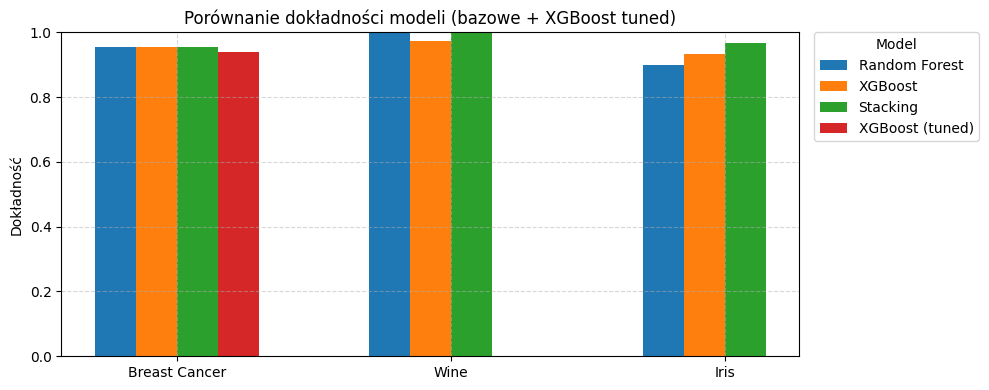


Final accuracy prints (format: print("Accuracy:", accuracy_score(y_test, y_pred)))
[Breast Cancer] Random Forest -> Dokładność: 0.956140350877193
[Breast Cancer] XGBoost -> Dokładność: 0.956140350877193
[Breast Cancer] Stacking -> Dokładność: 0.956140350877193
[Wine] Random Forest -> Dokładność: 1.0
[Wine] XGBoost -> Dokładność: 0.9722222222222222
[Wine] Stacking -> Dokładność: 1.0
[Iris] Random Forest -> Dokładność: 0.9
[Iris] XGBoost -> Dokładność: 0.9333333333333333
[Iris] Stacking -> Dokładność: 0.9666666666666667


In [15]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer, load_wine, load_iris
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

use_xgb = False
try:
    from xgboost import XGBClassifier
    use_xgb = True
except Exception:
    XGBClassifier = None
    use_xgb = False

print("XGBoost available:", use_xgb)

# funkcja eksperymentu
def run_experiment(X, y, dataset_name="dataset", random_state=42):
    results = {}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=random_state)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc_rf = accuracy_score(y_test, y_pred)
    print(f"[{dataset_name}] Random Forest - Dokładność:", acc_rf)
    results['Random Forest'] = acc_rf
    
    # XGBoost lub fallback
    if use_xgb:
        xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state, verbosity=0)
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        acc_xgb = accuracy_score(y_test, y_pred)
        print(f"[{dataset_name}] XGBoost - Dokładność:", acc_xgb)
        results['XGBoost'] = acc_xgb
    else:
        hgb = HistGradientBoostingClassifier(random_state=random_state)
        hgb.fit(X_train, y_train)
        y_pred = hgb.predict(X_test)
        acc_hgb = accuracy_score(y_test, y_pred)
        print(f"[{dataset_name}] HistGradientBoosting (fallback) - Dokładność:", acc_hgb)
        results['XGBoost'] = acc_hgb
        xgb = None
    
    # Stacking z dodanym KNN
    svc = SVC(probability=True, random_state=random_state)
    knn = KNeighborsClassifier(n_neighbors=5)
    estimators = [
        ('rf', RandomForestClassifier(n_estimators=100, random_state=random_state)),
        ('svc', svc),
        ('knn', knn)
    ]
    stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000))
    stack.fit(X_train, y_train)
    y_pred = stack.predict(X_test)
    acc_stack = accuracy_score(y_test, y_pred)
    print(f"[{dataset_name}] Stacking (RF + SVC + KNN) - Dokładność:", acc_stack)
    results['Stacking'] = acc_stack
    
    return results, {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'rf': rf, 'xgb': (xgb if use_xgb else None), 'stack': stack}

# zbiory danych
datasets = {
    'Breast Cancer': load_breast_cancer(return_X_y=True),
    'Wine': load_wine(return_X_y=True),
    'Iris': load_iris(return_X_y=True)
}

all_results = {}
models_objects = {}

for name, (X, y) in datasets.items():
    print("\n--- Running for dataset:", name)
    res, objs = run_experiment(X, y, dataset_name=name)
    all_results[name] = res
    models_objects[name] = objs

# tuning XGBoost
if use_xgb and models_objects['Breast Cancer']['xgb'] is not None:
    print("\n>>> Tuning XGBoost (RandomizedSearchCV) on Breast Cancer training set...")
    X_train = models_objects['Breast Cancer']['X_train']
    y_train = models_objects['Breast Cancer']['y_train']
    xgb = XGBClassifier(eval_metric='logloss', random_state=42, verbosity=0)
    param_dist = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 4, 6, 8, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.5, 0.7, 1.0],
        'gamma': [0, 0.1, 0.2, 0.4]
    }
    rnd = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=20, cv=3,
                             scoring='accuracy', random_state=42, n_jobs=-1)
    rnd.fit(X_train, y_train)
    print("Best params:", rnd.best_params_)
    best_xgb = rnd.best_estimator_
    X_test = models_objects['Breast Cancer']['X_test']
    y_test = models_objects['Breast Cancer']['y_test']
    y_pred = best_xgb.predict(X_test)
    acc_tuned = accuracy_score(y_test, y_pred)
    print("Tuned XGBoost - Dokładność:", acc_tuned)
    all_results['Breast Cancer']['XGBoost (tuned)'] = acc_tuned

# tabela wyników
df_rows = []
for dataset_name, res in all_results.items():
    for model_name, acc in res.items():
        df_rows.append({'Dataset': dataset_name, 'Model': model_name, 'Dokładność': acc})
acc_df = pd.DataFrame(df_rows)
print("\nTabela wyników:\n", acc_df)

# wykres
datasets_list = acc_df['Dataset'].unique()
models_list = acc_df['Model'].unique()

fig, ax = plt.subplots(figsize=(10, 4))
x = np.arange(len(datasets_list))
width = 0.15
offset = - (len(models_list)-1)/2 * width

for i, model in enumerate(models_list):
    subset = acc_df[acc_df['Model'] == model]
    vals = [
        subset[subset['Dataset'] == d]['Dokładność'].values[0] if not subset[subset['Dataset'] == d].empty else np.nan
        for d in datasets_list
    ]
    ax.bar(x + offset + i*width, vals, width, label=model)

ax.set_xticks(x)
ax.set_xticklabels(datasets_list)
ax.set_ylim(0.0, 1.0)
ax.set_ylabel('Dokładność')
ax.set_title('Porównanie dokładności modeli (bazowe + XGBoost tuned)')
ax.grid(True, linestyle='--', alpha=0.5)

ax.legend(title="Model", loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

plt.tight_layout()
plt.show()

print("\nFinal accuracy prints (format: print(\"Accuracy:\", accuracy_score(y_test, y_pred)))")
for dataset_name, objs in models_objects.items():
    X_test = objs['X_test']
    y_test = objs['y_test']
    # Random Forest
    rf = objs['rf']
    y_pred = rf.predict(X_test)
    print(f"[{dataset_name}] Random Forest ->", "Dokładność:", accuracy_score(y_test, y_pred))
    # XGBoost or fallback
    xgb_model = objs.get('xgb', None)
    if xgb_model is not None:
        y_pred = xgb_model.predict(X_test)
        print(f"[{dataset_name}] XGBoost ->", "Dokładność:", accuracy_score(y_test, y_pred))
    # Stacking
    stack = objs['stack']
    y_pred = stack.predict(X_test)
    print(f"[{dataset_name}] Stacking ->", "Dokładność:", accuracy_score(y_test, y_pred))
